**Course link:**  
https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/4470538-comprenez-comment-un-ordinateur-voit-une-image

# 1.1/ Understand how a computer sees an image

In [2]:
from PIL import Image

# Charger l'image
img = Image.open("simba.png") 

# Afficher l'image chargée
img.show()

In [3]:
# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

Largeur : 250 px, hauteur : 263 px


In [4]:
# Afficher son mode de quantification
print("Format des pixels : {}".format(img.mode))

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20,100))
print("Valeur du pixel situé en (20,100) : {}".format(px_value))

Format des pixels : L
Valeur du pixel situé en (20,100) : 196


Note: 
- Le mode 'L' signifie que les intensités sont codées sur 8 bits, ce qui est équivalent aux 256 niveaux de gris d'une image en noir et blanc. Tous les modes possibles sont répertoriés dans la documentation de Pillow.
- Par convention dans Pillow, le repère cartésien a pour origine le pixel le plus en haut à gauche de l'image, et l'axe des ordonnées est orienté vers le bas. 

In [6]:
import numpy as np

# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img)

# Afficher la taille de la matrice de pixels
print("Taille de la matrice de pixels : {}".format(mat.shape))

mat

Taille de la matrice de pixels : (263, 250)


array([[247, 245, 245, ..., 224, 228, 228],
       [246, 244, 243, ..., 228, 230, 230],
       [244, 242, 240, ..., 230, 231, 231],
       ...,
       [183, 169, 169, ..., 108,  95, 102],
       [170, 160, 171, ...,  81,  95,  99],
       [150, 155, 174, ..., 133, 115, 111]], dtype=uint8)

Attention à l'inversion ligne/colonne et abscisse/ordonnée : l'intensité du pixel d'abscisse x et d'ordonnée y correspond à l'élément de la matrice situé à la y-ème ligne et x-ème colonne ! 

# 1.2/ Image processing

## Histogram manipulation

Les techniques de traitement d'images basées sur la modification d'histogrammes font partie de la classe des traitements dits ponctuels : la valeur de chaque pixel est corrigée, et ce indépendamment des autres pixels.  
Lorsque l'histogramme est normalisé, il indique en ordonnée la probabilité pi de trouver un pixel de niveau de gris i dans l'image.  
Un histogramme cumulé normalisé calcule le pourcentage de pixels ayant une valeur inférieure à un niveau de gris donné.

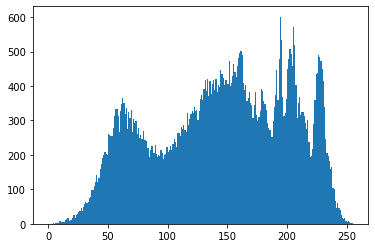

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Charger l'image comme matrice de pixels
img = np.array(Image.open('simba.png'))

# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(img.flatten(), bins=range(256))
plt.show()

Grossièrement, à gauche se situent les pixels noirs, à droite les pixels blancs, et au milieu, toutes les nuances de gris.

**Étirement d’histogrammes**

Pour corriger les défauts liés à l’exposition d'une image, il suffit simplement d'étirer son histogramme : l'objectif est d'étendre les valeurs des niveaux de gris de l'image mal exposée, majoritairement répartis dans un sous intervalle [Imin,Imax]⊂[0,255] , à tout l'intervalle disponible.  
Cette transformation se fait simplement à l’aide de la règle de trois : la valeur de chaque pixel est remplacée par le résultat de la formule ci-dessous.
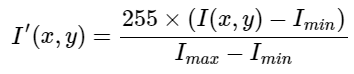
L'étirement d'histogramme se fait avec la fonction `autocontrast` du module ImageOps de Pillow. 

**Égalisation d’histogrammes**

L'objectif est donc d'harmoniser la distribution des niveaux de gris de l'image, de sorte que chaque niveau de l'histogramme contienne idéalement le même nombre de pixels. Concrètement, on essaye d'aplatir au maximum l'histogramme original.  
Pour cela, nous calculons d'abord l'histogramme cumulé normalisé de l'image, puis nous ajustons la valeur de chaque pixel en utilisant la formule mathématique suivante : 
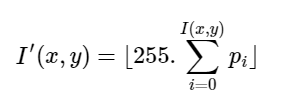
où pi désigne la probabilité qu'un pixel de l'image initiale soit d'intensité i. 
L'égalisation d'histogramme correspond à la fonction  `PIL.ImageOps.equalize` . 

## Geometric transformations

Une transformation géométrique est caractérisée par une matrice et un vecteur réels, respectivement notés T et V. 
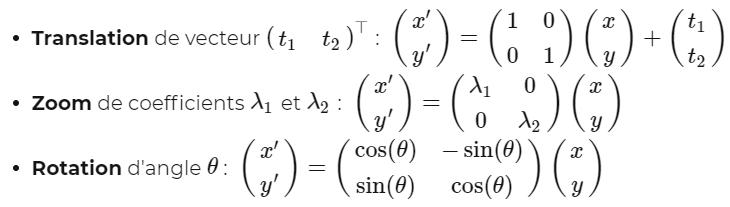

Il existe deux modes d'interpolation principaux :
- L'interpolation au plus proche voisin : la nouvelle valeur est déterminée comme l'intensité du pixel le plus proche. Il s'agit de la technique d'interpolation la plus simple et la plus rapide, mais en contrepartie, elle offre une moins bonne qualité visuelle.
- L'interpolation bilinéaire : la nouvelle valeur est calculée à partir des intensités des quatre pixels voisins.

## Noise elimination

On parle de bruit additif lorsque l'image bruitée est la somme de l'image originale et du bruit. Un exemple très classique de bruit additif est le bruit gaussien, pour lequel les intensités sont choisies aléatoirement selon une loi normale.  
Il existe d'autres types de bruits, comme le bruit impulsionnel : un certain pourcentage de pixels dans l'image est remplacé par une valeur tirée uniformément sur [0,255]

In [9]:
# Charger l'image sous forme d'une matrice de pixels
img = np.array(Image.open('simba.png'))

# Générer le bruit gaussien de moyenne nulle et d'écart-type 7 (variance 49)
noise = np.random.normal(0, 7, img.shape)

# Créer l'image bruitée et l'afficher
noisy_img = Image.fromarray(img + noise).convert('L')
noisy_img.show()

Plusieurs techniques de débruitage (ou lissage) ont été développées afin d'atténuer le bruit dans une image. Le **lissage par moyennage** désigne la solution la plus intuitive.  
En Pillow, le lissage par moyennage est implémenté dans la classe `PIL.ImageFilter.BoxBlur` et il s'applique avec la méthode  `PIL.Image.filter` :  

In [11]:
from PIL import ImageFilter

# Appliquer le lissage par moyennage (fenêtre de taille 9) et afficher le résultat
noisy_img.filter(ImageFilter.BoxBlur(1)).show()

# 1.3/ Filter an image

**Les filtres linéaires**  
Une propriété importante d'un filtre linéaire est l'invariance par translation : la modification d'un pixel dépend de son voisinage, et non de sa position dans l'image.

**L'opérateur de convolution**  
Un filtre linéaire remplace la valeur de chaque pixel en entrée par une combinaison linéaire des intensités de ses pixels voisins. L'opérateur permettant d’effectuer cette transformation est appelé produit de convolution.  
En notant ∗ l'opérateur de convolution, la relation mathématique entre l'image initiale X et l'image filtrée Y pour tout type de filtre linéaire s'écrit Y=H∗X.  
H  est le noyau (ou masque) de convolution : il s'agit d'une matrice carrée de taille impaire 2k+1, qui caractérise le filtre linéaire appliqué. 

Notez que le produit de convolution est bien un opérateur linéaire invariant par translation puisqu'il est seulement construit à partir de multiplications et d'additions.

**Exemples de filtres courants**  
- Filtre Gaussien : Un filtre gaussien est un filtre linéaire dont les éléments du noyau de convolution sont déterminés selon la densité d'une loi gaussienne centrée à 2 dimensions. Le filtre gaussien s'applique en Pillow avec la méthode  `PIL.Image.filter` et la classe `PIL.ImageFilter.GaussianBlur`, dont le paramètre radius en entrée désigne σ. La performance du filtre gaussien dépend de la valeur de sa variance : plus l'image est bruitée, plus on doit augmenter la variance, mais plus l'image devient floue.   
.
- Filtre médian (non-linéaire) : la valeur de chaque pixel est remplacée par la médiane (et non la moyenne) de son voisinage. Les filtres non-linéaires sont des filtres dont le fonctionnement ne peut être défini comme un produit de convolution.  

# 2.1/ The notion of "features" in an image

**Le template matching avec les filtres**  

Le template matching réalisé avec des filtres utilise l'opérateur de **corrélation croisée** (cross-correlation), noté ⊗. Cet opérateur transforme l'image de représentation matricielle X en une nouvelle image Y.  
Dans ce contexte, H est une petite image représentant le template à retrouver. Concrètement, cette opération revient à faire glisser H sur l'image X, à multiplier les pixels qui se superposent et à sommer ces produits.  
La nouvelle image Y, appelée **carte de corrélation**, nous indique où le template a été détecté : plus une région est claire (d'intensités élevées), plus elle ressemble au template recherché.

**Features**  

A chaque feature détectée est associé un vecteur, appelé descripteur (feature descriptor ou feature vector).  
La résolution du problème d'image matching se fait alors en deux étapes :
- Détecter et décrire les features dans chaque image
- Trouver les paires de features qui se correspondent dans les deux images (features matching)

Une zone constitue un bon choix de features si elle est :
- Répétable : présente des propriétés d'invariance aux transformations géométriques et photométriques;
- Distinctive : suffisamment unique et non-ambiguë;
- Locale : une feature doit correspondre à une zone suffisamment petite, et elle est décrite selon son voisinage uniquement. 

# 2.2/ Detect corners and edges in an image

**La detection des bords avec le filtre de Canny**

Mathématiquement, la détection des bords revient à chercher les points de l'image où la fonction d'intensité I varie brusquement. Or, nous savons qu'une amplitude du gradient élevée indique un fort changement d'intensité. Le but est donc de chercher les maxima locaux de ||∇I||.

**La localisation des coins avec le détecteur de Harris-Stephens**

Les coins se situent dans les régions où l'intensité varie fortement dans au moins deux directions.

# 2.3/ Effectively describe the features detected with SIFT

L'algorithme **SIFT (Scale-invariant feature transform)**, développé en 1999 et très populaire dans le domaine de la vision par ordinateur, permet d'extraire des features (ou points d'intérêt) de l'image et de calculer leurs descripteurs.  
L'algorithme SIFT se divise en plusieurs étapes :
- Détection : création de l'espace des échelles, calcul des "DoG", localisation des points d'intérêt
- Description : assignation d'orientation, création des descripteurs

**Detecteur SIFT**  

Chaque feature est une zone circulaire intéressante, repérée par son centre (point d'intérêt), et dont le rayon est proportionnel à son échelle caractéristique. La force du détecteur SIFT est sa capacité à trouver des rayons différents, et donc des features de différentes tailles.   
Pour détecter des features de différentes tailles, on construit l'espace des échelles. Cela consiste à flouter notre image et à réduire sa taille plusieurs fois. Chaque fois qu'on réduit l'image, on définit une nouvelle octave. **DoG ( Difference of Gaussians)** désigne une image obtenue en faisant la soustraction de deux images successives (deux flous Gaussiens de paramètres σ et kσ) dans une octave.  
Les points d'intérêts font partie des extrema locaux de l'ensemble des DoG. 

**Descripteur SIFT**  
- Assignation d'orientation : Cette étape consiste à déterminer l'orientation de chacun des points d'intérêts afin de rendre le descripteur invariant par rotation. L'orientation d'un point d'intérêt est la direction du gradient la plus rencontrée autour de ce point.

- Création des descripteurs : on considère une fenêtre carrée de taille  12σ×12σ  pixels centrée autour d'un point d'intérêt et proportionnelle à son niveau de flou de détection σ . On découpe celle-ci en 16 petites fenêtres carrées, chacune de taille 3σ×3σ  pixels. Pour chacune des 16 fenêtres, un histogramme des orientations du gradient est construit, où les orientations sont décrites par rapport à l'orientation du point d'intérêt.

# 2.4/ Use features to classify images

Les trois étapes d'un algorithme de classification d'images : 
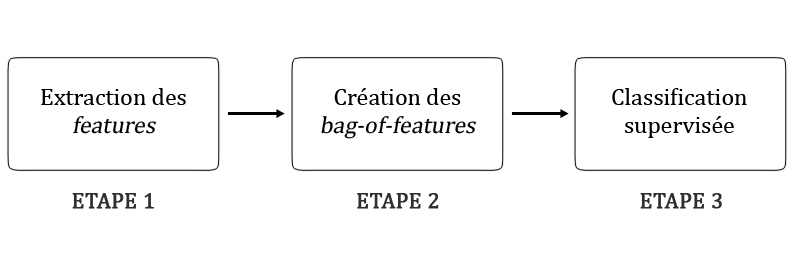

Etape 1 : En pratique, on utilise seulement SIFT pour détecter et décrire les features.

Etape 2 : Un **bag-of-features** représente une image par un vecteur créé en deux temps : d'abord, on crée les "visual words", puis on construit un histogramme. 
- Pour créer le "dictionnaire" de visual words, il suffit d'appliquer un algorithme de clustering aux descripteurs de features construits à l'étape 1, comme le k-means. Les visual words correspondent alors aux centres des clusters trouvés.
- Pour chaque image, on crée un histogramme qui indique la fréquence d'apparition de chaque visual word dans l'image.  

Finalement, le bag-of-features d'une image est le vecteur dans lequel on a stocké les valeurs de l'histogramme et qu'on a normalisé (en divisant par la norme euclidienne). 

Etape 3 : on va entraîner un algorithme d'apprentissage supervisé sur les bag-of-features construits à l'étape 2. 

# 3.1/ What is a convolutional neural network (CNN)? 

Les réseaux de neurones convolutifs désignent une sous-catégorie de réseaux de neurones spécialement conçus pour traiter des images en entrée. Leur architecture est alors plus spécifique : elle est composée de deux blocs principaux.

- Le premier bloc fonctionne comme un extracteur de features

- Le deuxieme bloc transforme les valeurs du vecteur en entrée (feature maps) pour renvoyer les probabilités d'apppartenance a chaque classe.

Comme pour les réseaux de neurones ordinaires, les paramètres des couches sont déterminés par rétropropagation du gradient. Mais dans le cas des CNN, ces paramètres désignent en particulier les features des images.

# 3.2/ The different layers of a CNN

Il existe quatre types de couches pour un réseau de neurones convolutif.

**La couche de convolution**  
Son but est de repérer la présence d'un ensemble de features dans les images reçues en entrée. Pour cela, on réalise un filtrage par convolution : le principe est de faire "glisser" une fenêtre représentant la feature sur l'image, et de calculer le produit de convolution entre la feature et chaque portion de l'image balayée.  
Contrairement aux méthodes traditionnelles, les features ne sont pas pré-définies selon un formalisme particulier (par exemple SIFT), mais apprises par le réseau lors la phase d'entraînement ! 

**La couche de pooling**  
Souvent placée entre deux couches de convolution, elle reçoit en entrée plusieurs feature maps, et applique à chacune d'entre elles l'opération de pooling. L'opération de pooling consiste à réduire la taille des images, tout en préservant leurs caractéristiques importantes.  
La couche de pooling permet de réduire le nombre de paramètres et de calculs dans le réseau, et rend le réseau moins sensible à la position des features.

**La couche de correction ReLU**  
ReLU (Rectified Linear Units) désigne la fonction réelle non-linéaire définie par ReLU(x)=max(0,x).

**La couche fully-connected**  
La couche fully-connected constitue toujours la dernière couche d'un réseau de neurones.  
Elle permet de classifier l'image en entrée du réseau : elle renvoie un vecteur de taille N, où N est le nombre de classes dans notre problème de classification d'images.

# 3.3/ Build a CNN and gain time with transfer learning

Tous les réseaux de neurones convolutifs doivent commencer par une couche de convolution et finir par une couche fully-connected. En général, un réseau de neurones empile plusieurs couches de convolution et de correction ReLU, ajoute ensuite une couche de pooling (facultative), et répète ce motif plusieurs fois; puis, il empile des couches fully-connected.  

**Le paramétrage des couches**  
La couche de convolution possède quatre hyperparamètres : le nombre de filtres K, la taille F des filtres, le pas S, le zero-padding  P. Choisir P=(F−1)/2 et S=1 permet ainsi d'obtenir des feature maps de même largeur et hauteur que celles reçues en entrée.   
La couche de pooling présente seulement deux hyperparamètres : la taille F des cellules et le pas S.  
Le choix des hyperparamètres se fait selon un schéma classique :
- Pour la couche de convolution, en général, on choisit F=3,P=1,S=1 ou F=5,P=2,S=1.
- Pour la couche de pooling, F=2 et S=2 est un choix judicieux. Cela permet d'éliminer 75% des pixels en entrée. On peut également trouver F=3 et S=2 : dans ce cas, les cellules se chevauchent.

En pratique, la stratégie la plus efficace consiste à prendre un réseau existant qui classifie bien une large collection d'images (comme ImageNet) et d'appliquer le Transfer Learning.

**Le Transfer Learning**  
 Le principe est d'utiliser les connaissances acquises par un réseau de neurones lors de la résolution d'un problème afin d'en résoudre un autre plus ou moins similaire. Nous pouvons exploiter le réseau de neurones pré-entraîné de plusieurs façons, en fonction de la taille du jeu de données en entrée et de sa similarité avec celui utilisé lors du pré-entraînement.